In [1]:
import numpy as np
from scipy.stats import norm, entropy, wasserstein_distance

import xarray as xr
import numpy as np
import datetime
import time
import cartopy

import xarray as xr
import numpy as np
import matplotlib
import datetime

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.widgets import Slider
import cartopy
import random
import cf_xarray as cfxr
import pandas as pd
plt.rcParams.update({'font.size': 18})  

In [7]:
#sample = "DE-Hai_51.08_10.45_v0.zarr"  
sample = "custom_cube_50.90_11.56.zarr" # Jena
#sample = "DE-Lnf_51.33_10.37_v0.zarr" 
#sample = "ES-Cnd_37.91_-3.23_v0.zarr" 
#

# Load Eco cluster of a single location
base_path = f"/Net/Groups/BGI/scratch/crobin/PythonProjects/ExtremesProject/experiments/2025-04-14_12:48:54_full_fluxnet_therightone_highveg/EVI_EN/{sample}"
def load_and_decode(sub_path, var_name):
    ds = xr.open_zarr(f"{base_path}/{sub_path}.zarr")
    return cfxr.decode_compress_to_multi_index(ds, "location")[var_name]
eco_cluster = load_and_decode("eco_clusters", "eco_clusters")

# Load the eco-clusters and (deseasonalized) data of the training set
path_clsrs = "/Net/Groups/BGI/scratch/crobin/PythonProjects/ExtremesProject/experiments/2025-04-14_12:48:54_full_fluxnet_therightone_highveg/EVI_EN/eco_clusters.zarr"
ds = xr.open_zarr(path_clsrs)
eco_cluster_training = cfxr.decode_compress_to_multi_index(ds, "location").eco_clusters

path_clsrs = "/Net/Groups/BGI/scratch/crobin/PythonProjects/ExtremesProject/experiments/2025-04-14_12:48:54_full_fluxnet_therightone_highveg/EVI_EN/deseasonalized.zarr"
ds = xr.open_zarr(path_clsrs)
deseasonalized_training = cfxr.decode_compress_to_multi_index(ds, "location").deseasonalized



# Load the (deseasonalized) data of the same location in MODIS
base_path_modis =  f"/Net/Groups/BGI/scratch/crobin/PythonProjects/ExtremesProject/experiments/2025-04-14_13:17:58_full_fluxnet_therightone_highveg_modis/EVI_MODIS/{sample}/deseasonalized.zarr"
deseasonalized_modis = xr.open_zarr(base_path_modis)
deseasonalized_modis = cfxr.decode_compress_to_multi_index(deseasonalized_modis, "location").deseasonalized

In [8]:
# Calculate mean and variance for each modis pixel
mean_modis = deseasonalized_modis.mean(dim="time")
std_modis = deseasonalized_modis.std(dim="time")

# Calculate mean and variance for each eco-cluster in the Sentinel-2 data
def _create_cluster_labels(eco_clusters):
    """Create cluster labels for grouping."""
    unique_clusters, _ = np.unique(
        eco_clusters.values, axis=0, return_counts=True
    )
    labels = xr.DataArray(
        data=np.argmax(
            np.all(
                eco_clusters.values[:, :, None]
                == unique_clusters.T[None, :, :],
                axis=1,
            ),
            axis=1,
        ),
        dims=("location",),
        coords={"location": eco_clusters.location},
    )
    return unique_clusters, labels

unique_clusters, eco_cluster_labels = _create_cluster_labels(eco_cluster_training)
mean_s2_training = deseasonalized_training.groupby(eco_cluster_labels).mean(dim=["location", "time"])
std_s2_training = deseasonalized_training.groupby(eco_cluster_labels).std(dim=["location", "time"])

# Get the mean and variance of each unique eco-cluster in eco_cluster from the training data
def match_test_to_training_clusters(eco_cluster_test, unique_clusters):
    # Find which training cluster each test location matches
    matched_labels = np.argmax(
        np.all(
            eco_cluster_test.values[:, :, None] == unique_clusters.T[None, :, :],
            axis=1,
        ),
        axis=1,
    )
    return xr.DataArray(
        data=matched_labels,
        dims=("location",),
        coords={"location": eco_cluster_test.location},
    )
eco_cluster_test_labels = match_test_to_training_clusters(eco_cluster, unique_clusters)

mean_s2_sample = mean_s2_training.sel(group=eco_cluster_test_labels)
std_s2_sample = std_s2_training.sel(group=eco_cluster_test_labels)

In [9]:
def kl_divergence_gaussians(mu_p, sigma_p, mu_q, sigma_q):
        """
        KL divergence between two univariate Gaussians: P || Q
        """
        return np.log(sigma_q / sigma_p) + (sigma_p**2 + (mu_p - mu_q)**2) / (2 * sigma_q**2) - 0.5


results = kl_divergence_gaussians(
    mu_p=mean_modis,
    sigma_p=std_modis,
    mu_q=mean_s2_sample,
    sigma_q=std_s2_sample,)

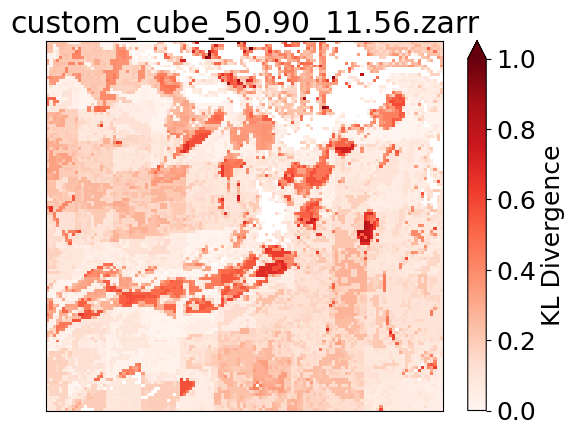

In [10]:
# Plot the data and grab the figure and axes
plot = results.unstack(dim="location").plot(vmin=0, vmax=1, cmap="Reds")

# Access the axes from the plot object
ax = plot.axes

# Remove x and y axis labels and ticks
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticks([])
ax.set_yticks([])

# Remove title
ax.set_title(f'{sample}')

# Update colorbar label
plot.colorbar.set_label('KL Divergence')

In [37]:
path = "/Net/Groups/BGI/scratch/crobin/PythonProjects/ExtremesProject/experiments/2025-04-14_12:48:54_full_fluxnet_therightone_highveg/EVI_EN/ES-Cnd_37.91_-3.23_v0.zarr/kl_divergence.zarr"
ds = xr.open_zarr(path)
kl_ds = cfxr.decode_compress_to_multi_index(ds, "location").kl_div


In [ ]:
path = "/Net/Groups/BGI/scratch/crobin/PythonProjects/ExtremesProject/experiments/2025-04-14_12:48:54_full_fluxnet_therightone_highveg/EVI_EN/ES-Cnd_37.91_-3.23_v0.zarr/kl_div_raoq.zarr"
ds = xr.open_zarr(path)

In [35]:
ds

<xarray.Dataset> Size: 2kB
Dimensions:      (raoq: 110)
Coordinates:
  * raoq         (raoq) float64 880B 0.02497 0.03013 0.03275 ... 0.5509 0.5807
    source_path  <U86 344B ...
Data variables:
    kl_div       (raoq) float64 880B dask.array<chunksize=(1,), meta=np.ndarray>

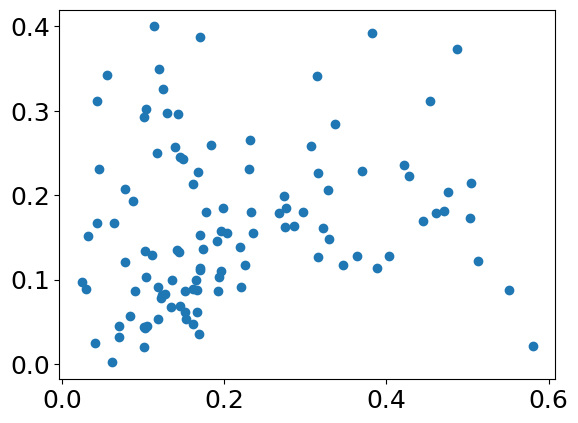

In [36]:
plt.plot(ds.raoq, ds.kl_div, 'o')

In [24]:
kl_ds

<xarray.DataArray 'raoq' (location: 15875)> Size: 127kB
dask.array<open_dataset-raoq, shape=(15875,), dtype=float64, chunksize=(15875,), chunktype=numpy.ndarray>
Coordinates:
  * location   (location) object 127kB MultiIndex
  * longitude  (location) float64 127kB 10.43 10.43 10.43 ... 10.47 10.47 10.47
  * latitude   (location) float64 127kB 51.09 51.09 51.09 ... 51.07 51.07 51.07

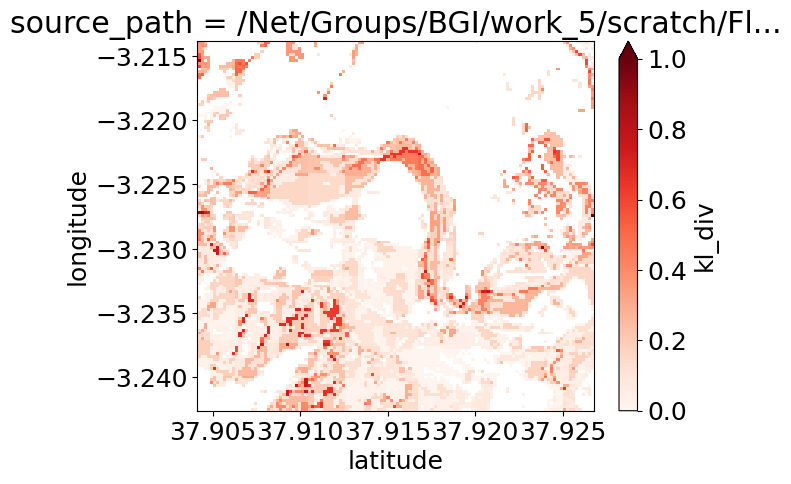

In [38]:
kl_ds.unstack(dim="location").plot(vmin=0, vmax=1, cmap="Reds")

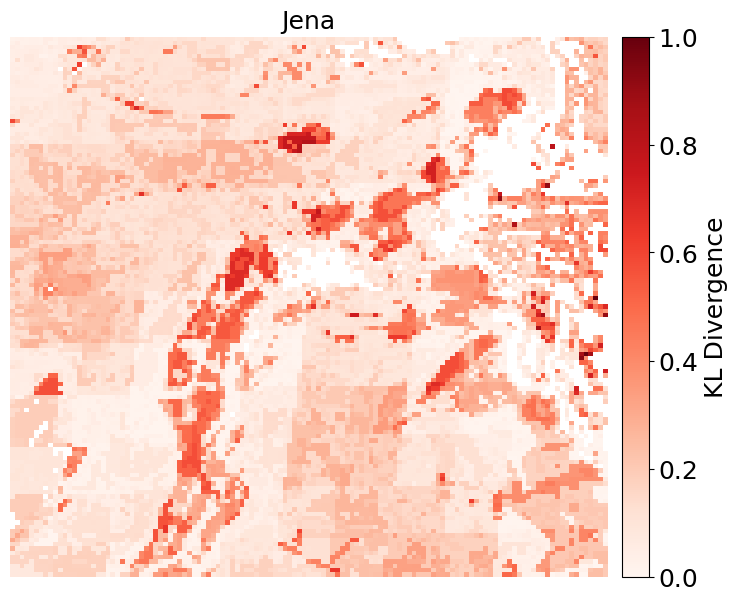

In [11]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.rcParams.update({'font.size': 18})
data = results.unstack(dim="location")
# Adjust the plot
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
# Plot the data with a colormap
pcm = ax.pcolormesh(
    data.longitude.values.T,
    data.latitude.values.T,
    data.values.T,
    cmap="Reds",  # viridis",  # Choose a colormap, e.g., 'viridis', 'plasma', 'coolwarm'
)
# Add a title
plt.title(f"Jena", fontsize=18)
# Add a colorbar
pcm.set_clim(0, 1)
ax.axis("off")  # Hide axes if the focus is on the raster
cbar = plt.colorbar(pcm, ax=ax, orientation="vertical", pad=0.02)
cbar.set_label("KL Divergence")  # Set the label for the colorbar

plt.show()

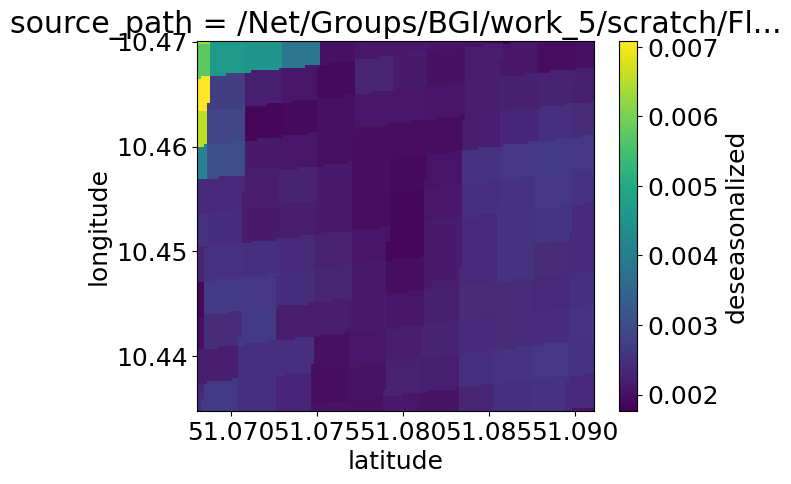

In [65]:
std_modis.unstack("location").plot()

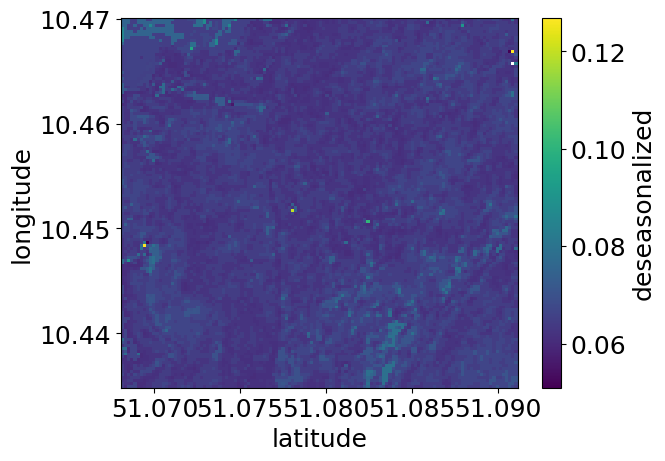

In [66]:
std_s2_sample.unstack("location").plot()

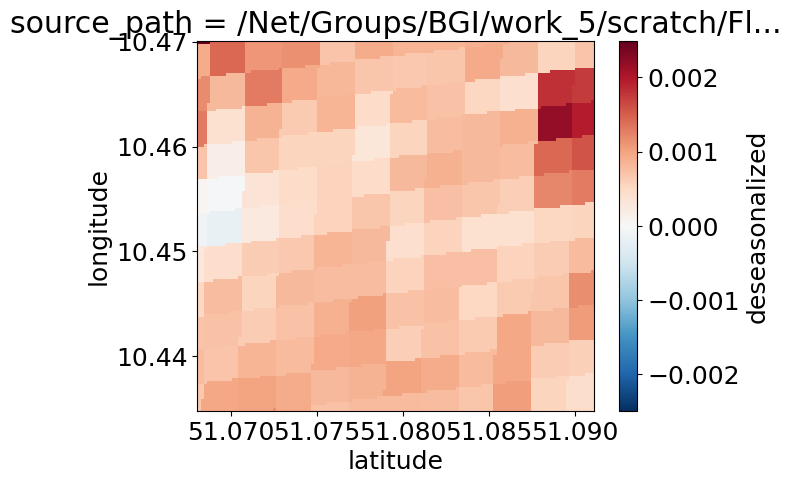

In [76]:
mean_modis.unstack("location").plot()

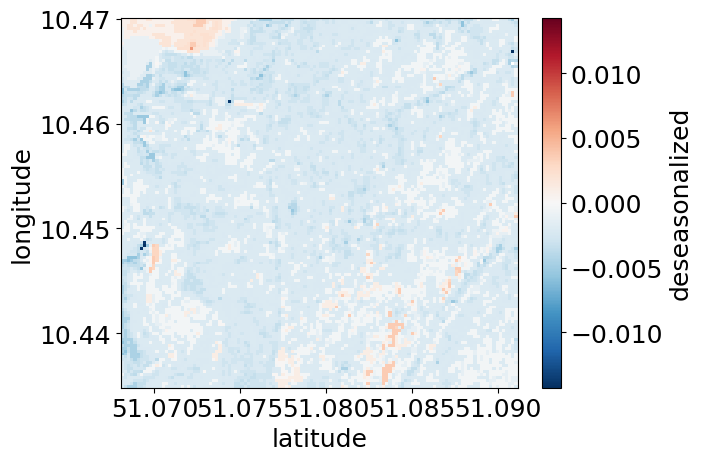

In [77]:
mean_s2_sample.unstack("location").plot()

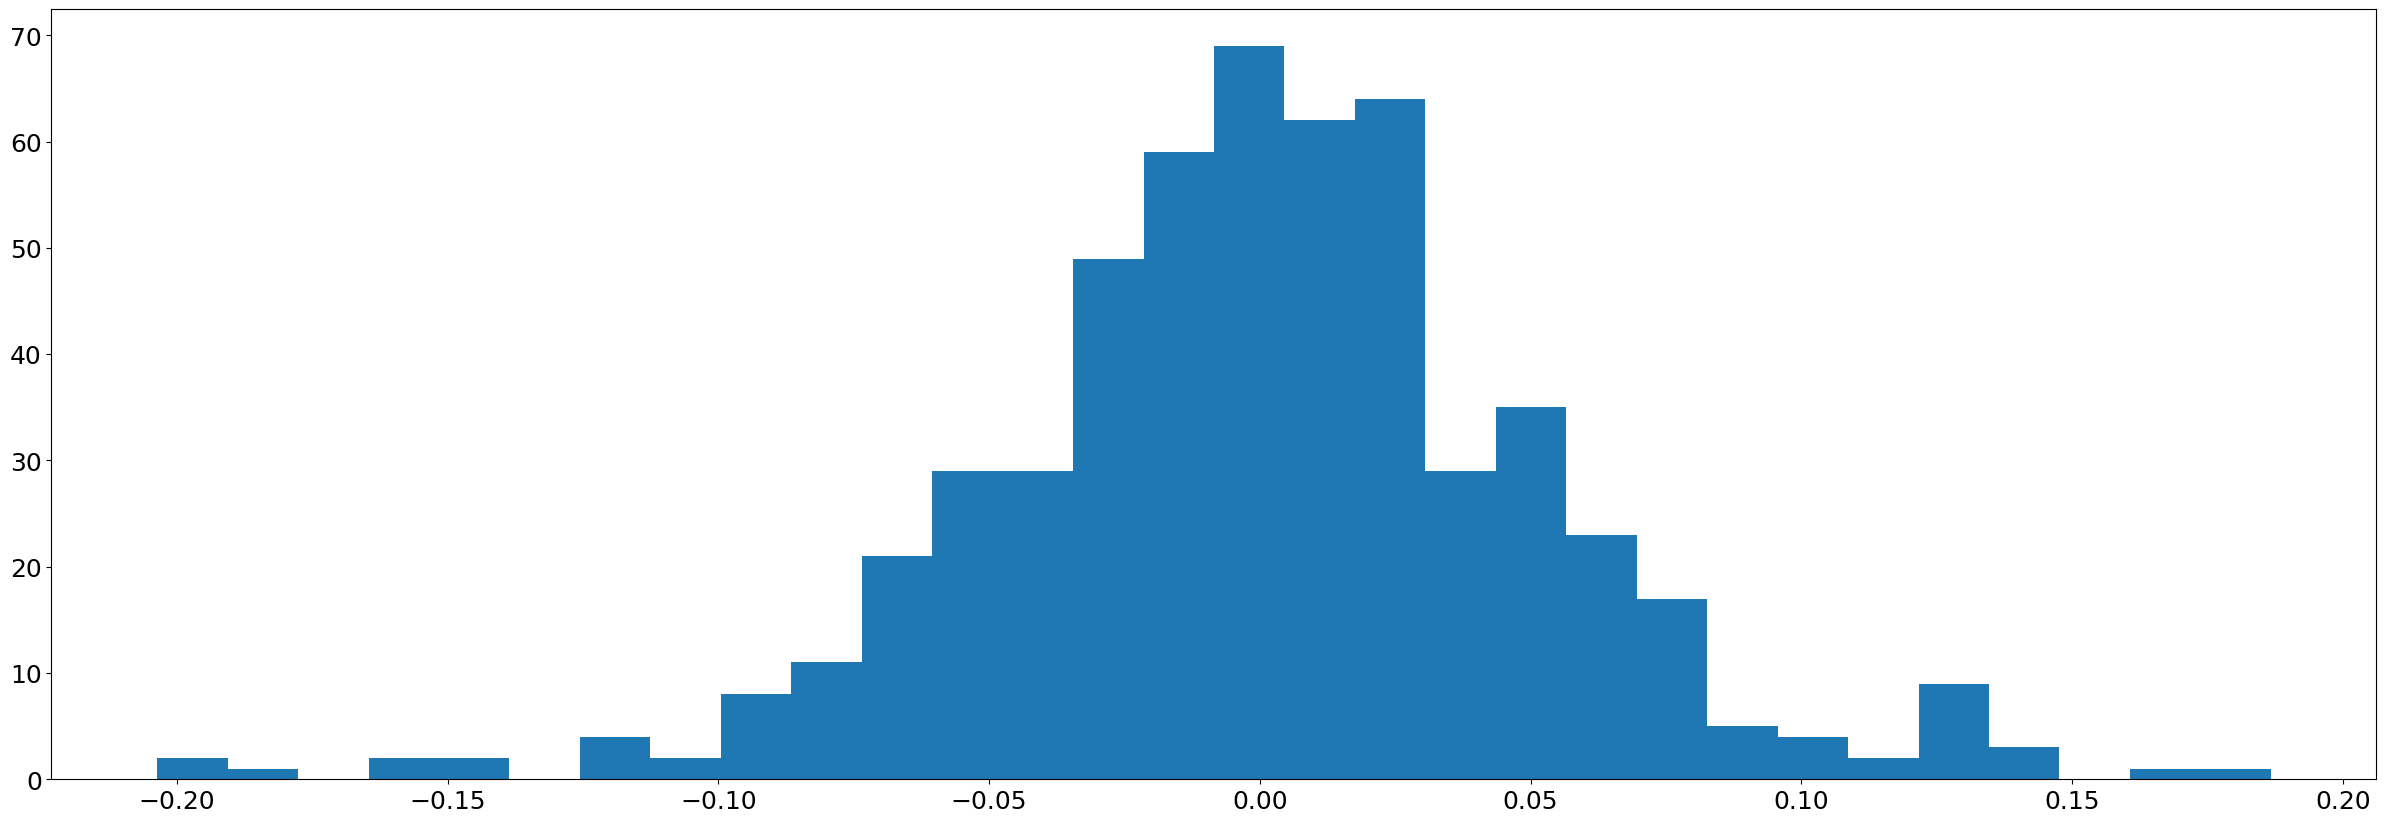

In [152]:
# Plot a modis pixel distribution
data = deseasonalized_modis.isel(location=1000).values
fig, ax = plt.subplots(figsize=(30, 10))
ax.hist(data, bins=30, zorder=1)
plt.show()

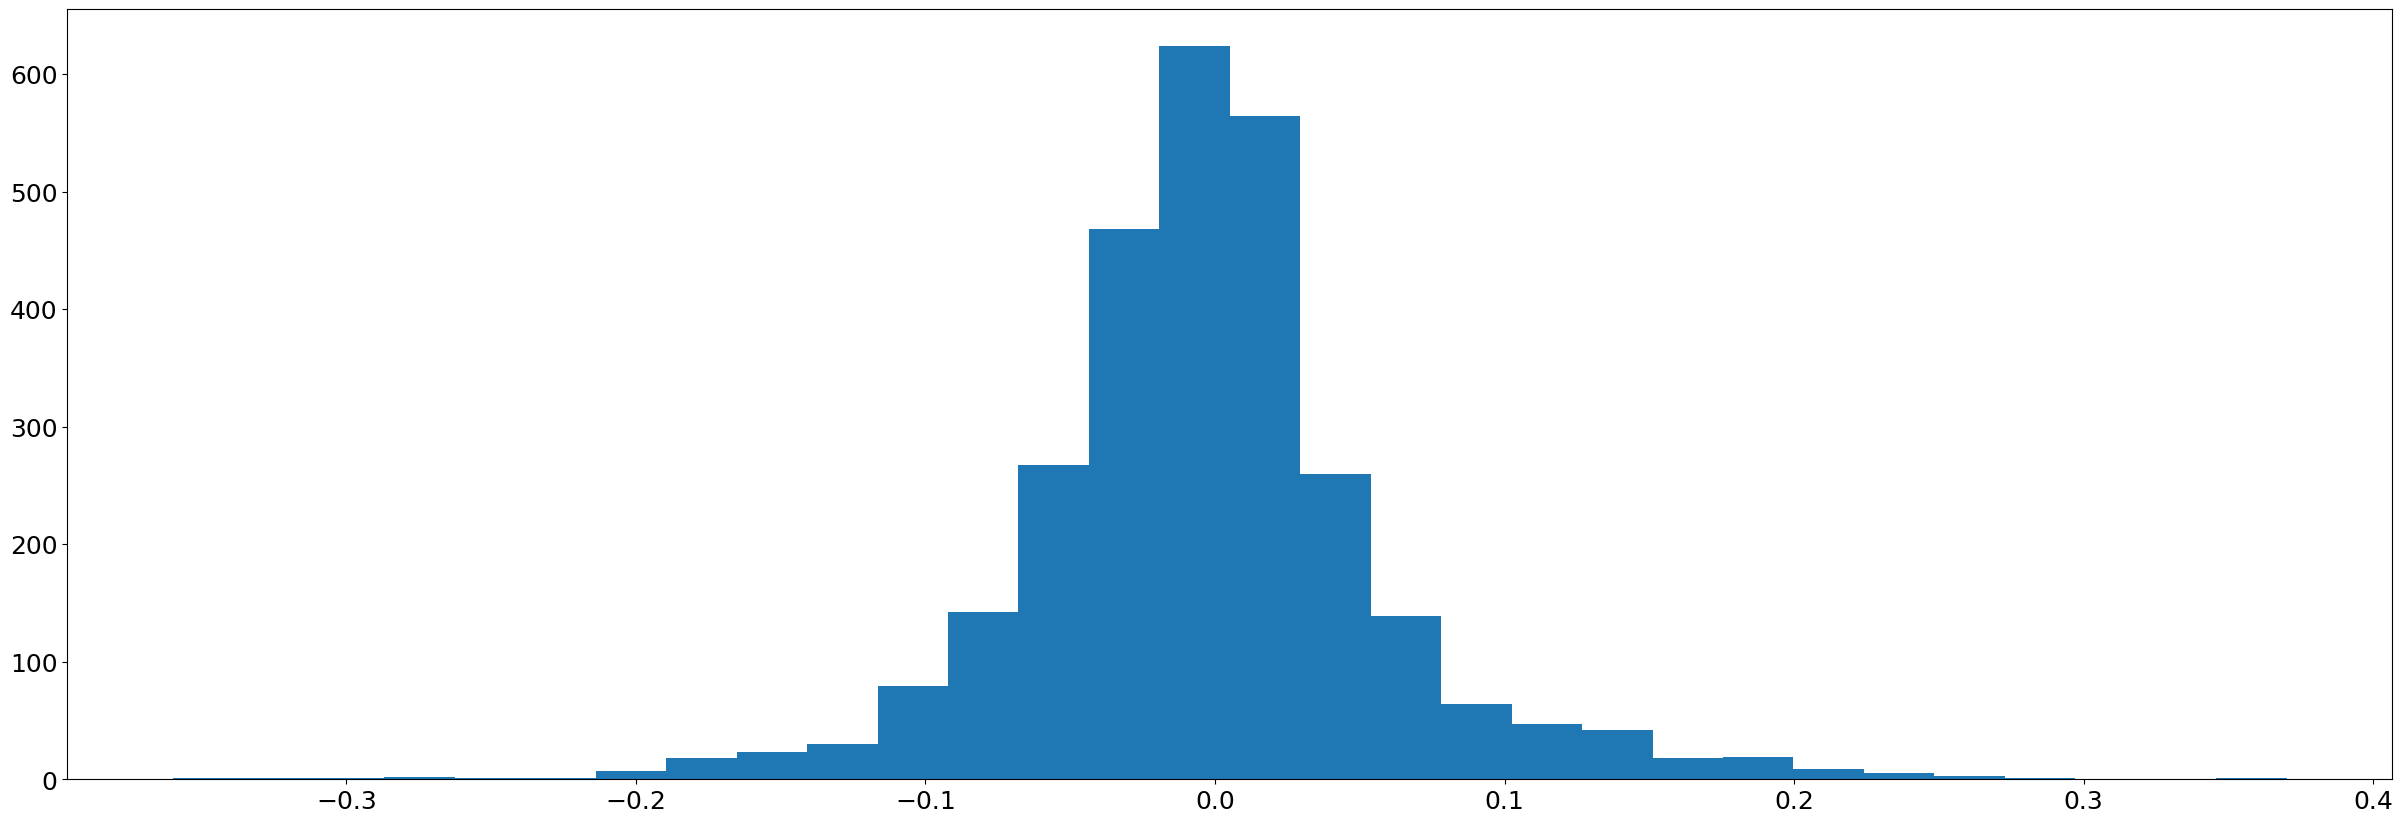

In [153]:
single_eco_cluster = eco_cluster.isel(location=1000)
eco_cluster_value = (single_eco_cluster.sel(component=0).values.item(), single_eco_cluster.sel(component=1).values.item(), single_eco_cluster.sel(component=2).values.item())
matching_mask = (eco_cluster_training.sel(component=0).values == eco_cluster_value[0]) & \
                (eco_cluster_training.sel(component=1).values == eco_cluster_value[1]) & \
                (eco_cluster_training.sel(component=2).values == eco_cluster_value[2])

# Extract the locations where all components match
single_cluster = eco_cluster_training[matching_mask]
data_cluster = np.ravel(deseasonalized_training.sel(location=single_cluster.location).values)
#data = data[~np.isnan(data)]  # Remove NaNs

fig, ax = plt.subplots(figsize=(30, 10))
ax.hist(data_cluster, bins=30, zorder=1)
plt.show()

KL Divergence: 37.85


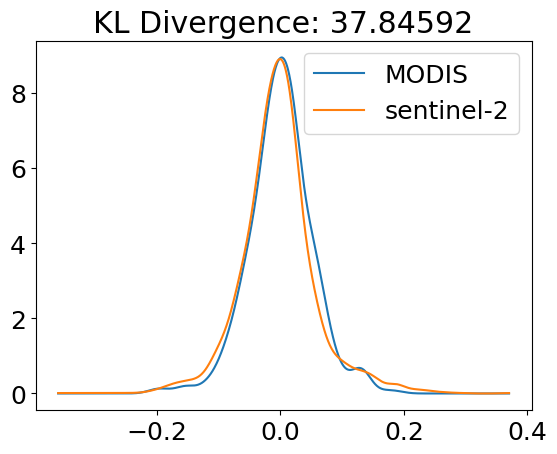

In [130]:
from scipy.stats import gaussian_kde
modis_data = data[np.isfinite(data)]
s2_data = data_cluster[np.isfinite(data_cluster)]
# Create KDEs
modis_kde = gaussian_kde(modis_data)
s2_kde = gaussian_kde(s2_data)


# Gaussian approximation
modis_mean, modis_std = np.mean(modis_data), np.std(modis_data)
s2_mean, s2_std = np.mean(s2_data), np.std(s2_data)

def kl_divergence(test_kde, ref_kde, grid, epsilon=1e-10):
    P_vals = test_kde(grid)
    Q_vals = ref_kde(grid)

    # Clip to avoid log(0)
    P_vals = np.clip(P_vals, epsilon, None)
    Q_vals = np.clip(Q_vals, epsilon, None)
    return np.sum(P_vals * np.log(P_vals / Q_vals))

min_val, max_val = min(np.nanmin(data_cluster), np.nanmin(data)), max(np.nanmax(data_cluster), np.nanmax(data))
grid = np.linspace(min_val, max_val, 1000)

# Gaussian PDFs
modis_gauss = norm.pdf(grid, loc=modis_mean, scale=modis_std)
s2_gauss = norm.pdf(grid, loc=s2_mean, scale=s2_std)



kl_div = kl_divergence(modis_kde, s2_kde, grid)
print(f"KL Divergence: {kl_div:.2f}")
fig, ax = plt.subplots()
ax.plot(grid, modis_kde(grid), label="MODIS")
ax.plot(grid, s2_kde(grid), label="sentinel-2")
ax.set_title(f"KL Divergence: {kl_div:.5f}")
ax.legend()
plt.show()

KL Divergence (KDE): 37.84592
KL Divergence (Gaussian): 43.62696
KL Divergence (Gaussian): 0.03188


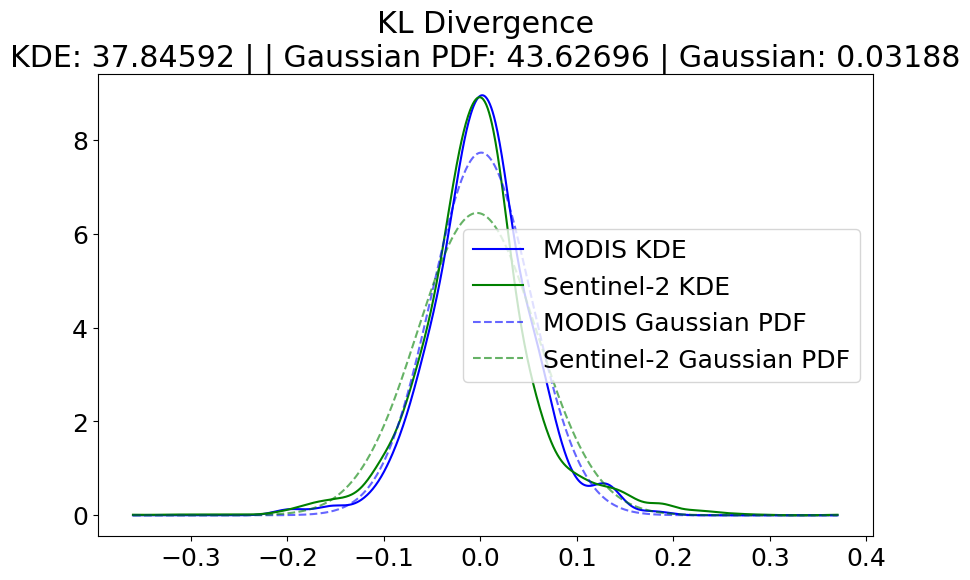

In [192]:
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# KDEs
modis_data = deseasonalized_modis.isel(location=1000).values[np.isfinite(deseasonalized_modis.isel(location=1000).values)]
s2_data = data_cluster[np.isfinite(data_cluster)]
modis_kde = gaussian_kde(modis_data)
s2_kde = gaussian_kde(s2_data)

# Gaussian approximation
modis_mean, modis_std = np.mean(modis_data), np.std(modis_data)
s2_mean, s2_std = np.mean(s2_data), np.std(s2_data)

# Grid
min_val = min(np.nanmin(modis_data), np.nanmin(s2_data))
max_val = max(np.nanmax(modis_data), np.nanmax(s2_data))
grid = np.linspace(min_val, max_val, 1000)

# Gaussian PDFs
modis_gauss = norm.pdf(grid, loc=modis_mean, scale=modis_std)
s2_gauss = norm.pdf(grid, loc=s2_mean, scale=s2_std)

# KL divergence function
def kl_divergence(P_vals, Q_vals, epsilon=1e-10):
    P_vals = np.clip(P_vals, epsilon, None)
    Q_vals = np.clip(Q_vals, epsilon, None)
    return np.sum(P_vals * np.log(P_vals / Q_vals))


def kl_divergence_gaussians(mu_p, sigma_p, mu_q, sigma_q):
        """
        KL divergence between two univariate Gaussians: P || Q
        """
        return np.log(sigma_q / sigma_p) + (sigma_p**2 + (mu_p - mu_q)**2) / (2 * sigma_q**2) - 0.5
# KL divergences
kl_kde = kl_divergence(modis_kde(grid), s2_kde(grid))
kl_gauss_pdf = kl_divergence(modis_gauss, s2_gauss)
kl_gauss = kl_divergence_gaussians(
    mu_p=modis_mean,
    sigma_p=modis_std,
    mu_q=s2_mean,
    sigma_q=s2_std,)

print(f"KL Divergence (KDE): {kl_kde:.5f}")
print(f"KL Divergence (Gaussian): {kl_gauss_pdf:.5f}")
print(f"KL Divergence (Gaussian): {kl_gauss:.5f}")

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(grid, modis_kde(grid), label="MODIS KDE", color='blue')
ax.plot(grid, s2_kde(grid), label="Sentinel-2 KDE", color='green')
ax.plot(grid, modis_gauss, '--', label="MODIS Gaussian PDF", color='blue', alpha=0.6)
ax.plot(grid, s2_gauss, '--', label="Sentinel-2 Gaussian PDF", color='green', alpha=0.6)
ax.set_title(f"KL Divergence\nKDE: {kl_kde:.5f} | | Gaussian PDF: {kl_gauss_pdf:.5f} | Gaussian: {kl_gauss:.5f}")
ax.legend()
plt.show()


In [170]:
# KDEs
modis_data = deseasonalized_modis.isel(location=1000).values[np.isfinite(deseasonalized_modis.isel(location=1000).values)]
s2_data = data_cluster[np.isfinite(data_cluster)]

# Gaussian approximation
modis_mean, modis_std = np.mean(modis_data), np.std(modis_data)
s2_mean, s2_std = np.mean(s2_data), np.std(s2_data)

def kl_divergence_gaussians(mu_p, sigma_p, mu_q, sigma_q):
        """
        KL divergence between two univariate Gaussians: P || Q
        """
        print(mu_p, sigma_p, mu_q, sigma_q)
        return np.log(sigma_q / sigma_p) + (sigma_p**2 + (mu_p - mu_q)**2) / (2 * sigma_q**2) - 0.5
# KL divergences

kl_gauss = kl_divergence_gaussians(
    mu_p=modis_mean,
    sigma_p=modis_std,
    mu_q=s2_mean,
    sigma_q=s2_std,)
kl_gauss


0.0009596339055456351 0.05160660422011923 -0.0033643069 0.061907142


0.0318805004359195

In [176]:
def kl_divergence_gaussians(mu_p, sigma_p, mu_q, sigma_q):
        """
        KL divergence between two univariate Gaussians: P || Q
        """
        print(mu_p, sigma_p, mu_q, sigma_q)
        return np.log(sigma_q / sigma_p) + (sigma_p**2 + (mu_p - mu_q)**2) / (2 * sigma_q**2) - 0.5

# Keep only finite values in the MODIS data
finite_modis = deseasonalized_modis.where(np.isfinite(deseasonalized_modis))

# Calculate mean and variance for each MODIS pixel
mean_modis = finite_modis.mean(dim="time")
std_modis = finite_modis.std(dim="time")

#mean_modis = deseasonalized_modis.mean(dim="time")
# std_modis = deseasonalized_modis.var(dim="time")

mean_s2_sample = mean_s2_training.sel(group=eco_cluster_test_labels)
std_s2_sample = std_s2_training.sel(group=eco_cluster_test_labels)

result_loc = kl_divergence_gaussians(
    mu_p=mean_modis.isel(location=1000).values,
    sigma_p=std_modis.isel(location=1000).values,
    mu_q=mean_s2_sample.isel(location=1000).values,
    sigma_q=std_s2_sample.isel(location=1000).values,)
result_loc

0.0009596339055456353 0.05160660422011922 -0.0033643069 0.06190714


0.031880474179284746

In [133]:
results.isel(location=1000).values

array(2.64945603)